# Assignment 1: Color Spaces, Morphological Operators

## Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in in /images.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



In [1]:
from dataclasses import dataclass
from typing import Tuple, Union

import numpy as np


class RgbSubscriptable:
    def __getitem__(self, key):
        if key == 0:
            return self.r
        if key == 1:
            return self.g
        if key == 2:
            return self.b
        raise KeyError("Key must be an int and one of {0, 1, 2}.")
    
    def __str__(self):
        return f"<{self.__class__.__name__} r={self.r} g={self.g} b={self.b}>"


class Threshold(RgbSubscriptable):
    NONE = None
    
    def __init__(self, r, g, b):
        self.r = r
        self.g = g
        self.b = b
    
    @classmethod
    def uniform(cls, n):
        return cls(n, n, n)
Threshold.NONE = Threshold.uniform(0)


class Color(RgbSubscriptable):
    def __init__(self, r, g, b, threshold=Threshold.NONE):
        self.r = r
        self.g = g
        self.b = b
        self.threshold = threshold


@dataclass
class ColorSpace:
    name: str
    colors: Tuple[Color]
    global_threshold: Threshold = Threshold.NONE
    RESULT: bool = False
    
    @classmethod
    def from_range(cls, r, g, b):
        means = (np.mean(r), np.mean(g), np.mean(b))
        return cls(
            colors=(
                Color(*means, threshold=Threshold(means[0] - r[0], means[1] - g[0], means[2] - b[0])),
            ),
        )
        
    def contains(self, check_color):
        return any(self._is_similar(own_color, check_color) for own_color in self.colors)
    
    def _is_similar(self, own_color, check_color):
        local_threshold = own_color.threshold
        global_threshold = self.global_threshold
        
        def comp_similar(i):
            comp_own = own_color[i]
            comp_check = check_color[i]
            thresh = local_threshold[i] + global_threshold[i]
            return comp_own - thresh <= comp_check <= comp_own + thresh
    
        return all(
            comp_similar(i) 
            for i in range(0, 3)
        ) 

    def __str__(self):
        colors = ', '.join(str(color) for color in self.colors)
        return f"<ColorSpace name='{self.name}' colors=({colors}) threshold={str(self.global_threshold)}>"

In [2]:
from skimage import io, data, color
import numpy as np


images = io.imread_collection('images/*')
RESULT = None


def handle_image(image, subspaces, draw_images=True):
    if image.shape[2] == 4:
        # simply drop alpha channel
        image = image[:,:,:-1]
    
    shape = image.shape
    print('shape =', shape)
    
    linear_shape = (image.shape[0]*image.shape[1], 3)
    linear_image = image.reshape(linear_shape)
    ones = np.full(linear_shape[1:], 255)

    binarized_images = []
    for i, subspace in enumerate(subspaces):
        print(subspace.name, '...........')
        binarized_image = np.full(linear_shape, 0)

        for i, pixel in enumerate(linear_image):
            if subspace.contains(pixel):
                binarized_image[i] = ones
        binarized_image = binarized_image.reshape(shape)
        if subspace.RESULT:
            global RESULT
            RESULT = (image, binarized_image)
        binarized_images.append(binarized_image)
    if draw_images:
        fig = io.imshow_collection([image] + binarized_images)
        for subspace, ax in zip(("",) + subspaces, fig.axes):
            ax.set_title(getattr(subspace, 'name', subspace))
        fig.tight_layout()
    return binarized_images


colors = (
    # BOTTLES
    (
        # 1. single color for each bottle
#         # bottle 1 (blueish)
#         ColorSpace(
#             name="blue, single color",
#             colors=(
#                 Color(0, 179, 215, Threshold(200, 50, 50)),
#             ),
#         ),
#         # bottle 2 (reddish)
#         ColorSpace(
#             name="red, single color",
#             colors=(
#                 Color(236, 75, 155, Threshold(50, 100, 50)),
#             ),
#         ),
        # bottle 3 (greenish)
        ColorSpace(
            RESULT=True,
            name="green, single color",
            colors=(
                Color(207, 220, 39, Threshold(60, 60, 160)),
            ),
        ),
        
        # 2. more colors per bottle, smaller threshold
#         # bottle 1
#         ColorSpace(
#             name="blue, multiple colors",
#             colors=(
#                 Color(0, 183, 215),
#                 Color(0, 188, 220),
#                 Color(0, 178, 216),
#                 Color(107, 204, 228),
#                 Color(155, 216, 235),
#                 Color(1, 158, 188),
#                 Color(83, 198, 224),
#                 Color(1, 76, 88),
#                 Color(1, 177, 207),
#                 Color(0, 167, 203),
#             ),
#             global_threshold=Threshold.uniform(20),
#         ),
        # picking colors for the other 2 bottles is no fun... :/
    ),


    # DOG
#     (
#         ColorSpace(
#             name="hat, green + orange",
#             colors=(
#                 # green
#                 Color(82, 236, 174),
#                 Color(23, 137, 79),
#                 Color(38, 176, 107),
#                 # orange
#                 Color(186, 45, 8),
#                 Color(89, 6, 0),
#                 Color(241, 122, 90),
#                 Color(248, 147, 103),
#                 Color(237, 91, 42),
#                 Color(188, 88, 49),
#             ),
#             global_threshold=Threshold(38, 38, 15),
#         ),
#     ),
)

i = -1
for image, subspaces in zip(images, colors):
    i += 1
#     if i != 1:
#         continue
    handle_image(image, subspaces)

# print('RESULT', RESULT)


shape = (293, 277, 3)
green, single color ...........


## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

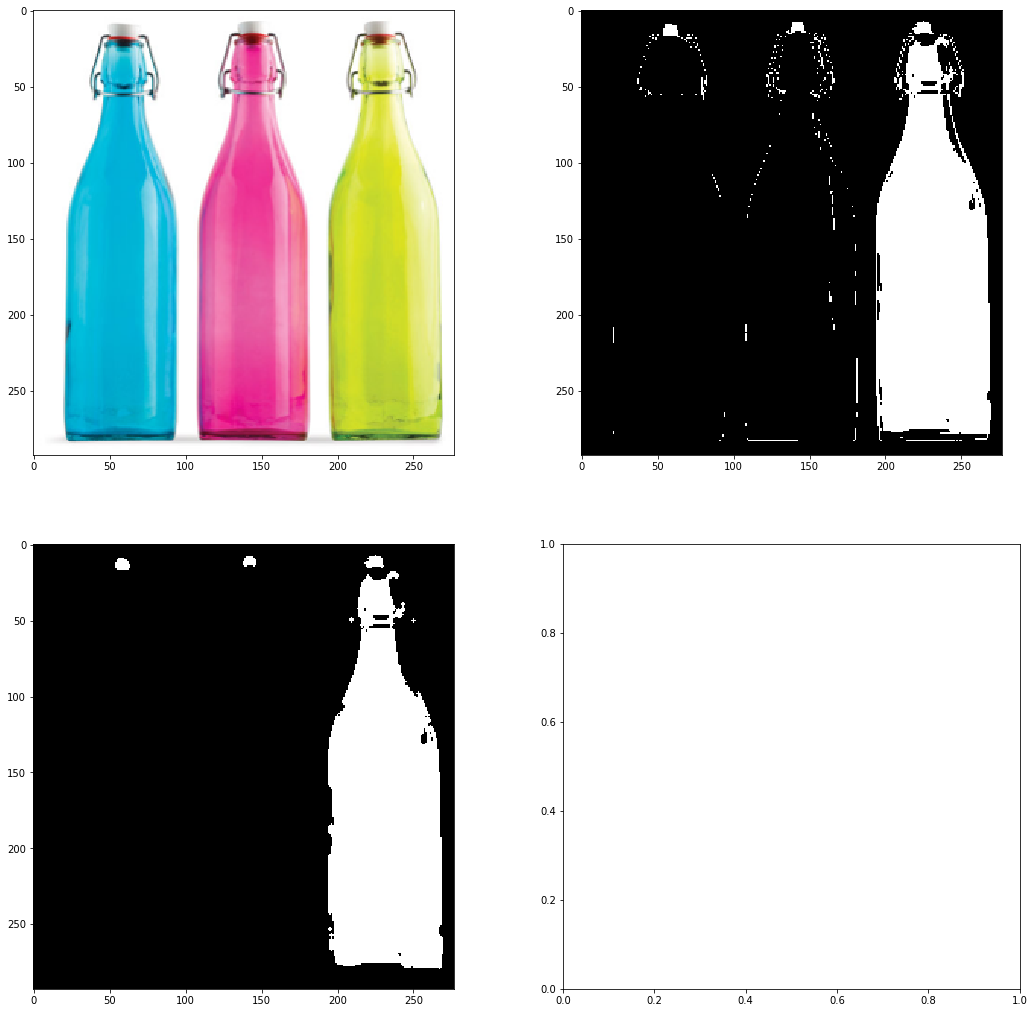

In [3]:
from skimage.morphology import binary_erosion, binary_dilation
from skimage.util import img_as_ubyte


original, binarized = RESULT

denoised = binary_dilation(binary_erosion(binarized))

fig = io.imshow_collection([original, binarized, img_as_ubyte(denoised)])
fig.set_figheight(18)
fig.set_figwidth(18)



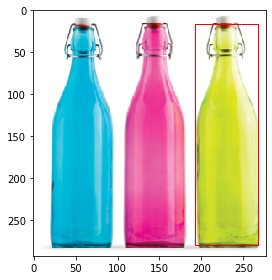

In [4]:
from collections import defaultdict
import sys

from skimage.draw import rectangle_perimeter


np.set_printoptions(
    threshold=sys.maxsize,
    linewidth=900,
)


@dataclass
class BoundingBox:
    top: int = None
    left: int = None
    bottom: int = None
    right: int = None
    
    def update(self, row, col):
        """Works only if pixels are iterated top-left to bottom-right."""
        if not self.top and not self.left:
            self.top = row
            self.left = col
        elif col < self.left:
            self.left = col
        self.bottom = row
        self.right = col

    @property
    def center(self):
        return np.mean(( (self.top, self.bottom), (self.left, self.right) ), axis=1).tolist()

    @property
    def size(self):
        return (self.bottom - self.top) * (self.bottom - self.top)


def two_pass_alogrithm(image, bbox_threshold=(10, 10)):
    # Combine color channels to single boolean values, and then map to {0,1}.
    image = np.logical_or.reduce(image, axis=2).astype(np.uint8)
    label_counter = 1
    equivalence_classes = []

    def get_eqclass(label):
        return next(s for s in equivalence_classes if label in s)
    
    def label_pixel(row, col):
        # background pixel => nothing of interest => nothing to do
        if not image[row, col]:
            return

        # We treat the background (zero values) as np.inf for more convenient calculation.
        left = np.inf
        top = np.inf
        if col > 0:
            left = int(image[row, col - 1]) or np.inf
        if row > 0:
            top = int(image[row - 1, col]) or np.inf

        # new label
        if left == np.inf and top == np.inf:
            nonlocal label_counter
            label = label_counter
            label_counter += 1
            equivalence_classes.append({label})
        else:
            low, high = (top, left) if top < left else (left, top)
            label = low
            # Connect 2 areas => merge according equivalence classes.
            if low != np.inf and high != np.inf and low != high:
                eqclass_low = get_eqclass(low)
                eqclass_high = get_eqclass(high)
                # Different labels may point to the same equivalence class
                if eqclass_low != eqclass_high:
                    equivalence_classes.remove(eqclass_low)
                    equivalence_classes.remove(eqclass_high)
                    equivalence_classes.append(eqclass_high | eqclass_low)

        image[row, col] = label

    rows, cols = image.shape[0:2]
    for row in range(rows):
        for col in range(cols):
            label_pixel(row, col)
    
    bboxes = defaultdict(BoundingBox)
    for row in range(rows):
        for col in range(cols):
            label = image[row, col]
            if label:
                corrected_label = min(get_eqclass(label))
                image[row, col] = corrected_label
                bboxes[corrected_label].update(row, col)
    
    bboxes = tuple(
        box
        for box in bboxes.values()
        if (
            box.bottom - box.top >= bbox_threshold[0]
            and box.right - box.left >= bbox_threshold[1]
        )
    )
    
    return bboxes, image


bboxes, _ = two_pass_alogrithm(denoised)
original_with_bboxes = np.copy(original)
bbox_color = np.array([255, 0, 0])
for bbox in bboxes:
    rr, cc = rectangle_perimeter(start=(bbox.top, bbox.left), end=(bbox.bottom, bbox.right))
    original_with_bboxes[rr, cc] = bbox_color

io.imshow(original_with_bboxes)


## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

222
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
shape = (480, 854, 3)
taco ...........
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)

shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
shape = (480, 854, 3)
taco ...........
[(), (), (), (), (), (), (BoundingBox(top=173, left=0, bottom=347, right=51),), (BoundingBox(top=172, left=0, bottom=347, right=51),), (BoundingBox(top=170, left=0, bottom=347, right=55),), (BoundingBox(top=170, left=0, bottom=347, right=57),), (BoundingBox(top=170, left=0, bottom=346, right=57),), (BoundingBox(top=170, left=2, bottom=345, right=62),), (BoundingBox(top=174, left=4, bottom=346, right=62),), (BoundingBox(top=171, left=6, bottom=345, right=64),), (BoundingBox(top=171, left=8, bottom=345, right=67),), (BoundingBox

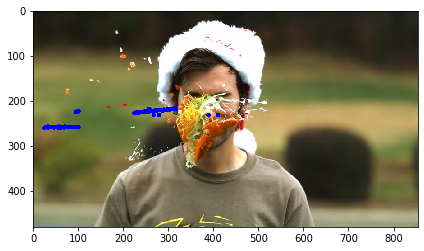

In [14]:
from multiprocessing import Pool

from skimage.draw import circle


images = io.imread_collection('images/taco/*')
print(len(images))

last_frame = images[-1]

color_spaces = (ColorSpace(
    name="taco",
    colors=(
        Color(255, 131, 9),
        Color(206, 79, 0),
        Color(241, 90, 3),
        Color(250, 164, 97),
    ),
    global_threshold=Threshold.uniform(40),
),)


BBOX_SIZE_THRESHOL = (50, 50)


def get_bboxes(image, threshold=BBOX_SIZE_THRESHOL):
    binarized = handle_image(image, color_spaces, draw_images=False)[0]
    denoised = binary_dilation(binary_erosion(binarized))
    bboxes, _ = two_pass_alogrithm(denoised, bbox_threshold=threshold)
    return bboxes

pool = Pool()
bboxes_per_image = pool.map(get_bboxes, images)

# centers_per_image = []
# for image in images:
#     binarized = handle_image(image, color_spaces, draw_images=False)[0]
#     denoised = binary_dilation(binary_erosion(binarized))
#     bboxes, _ = two_pass_alogrithm(denoised)
#     centers_per_image.append([box.center for box in bboxes])
# #     print(bboxes)

circle_colors = [[0, 0, 255], [255, 0, 0], [255, 255, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
print(bboxes_per_image)
last_frame_with_history = np.copy(last_frame)
for bboxes in bboxes_per_image:
    # TODO: select center based on previous position!
    print(bboxes)
    bboxes = sorted(bboxes, key=lambda box: box.size, reverse=True)
    for i, box in enumerate(bboxes):
        rr, cc = circle(*box.center, radius=(5 / (i + 1)), shape=last_frame.shape)
        last_frame_with_history[rr, cc] = circle_colors[i]

io.imshow(last_frame_with_history)